# COMP 551 - Kaggle Competition - JuBeKa - CNN

#### I took part in the Kaggle competition with two other team members. We competed against 55 other teams in COMP-551 at McGill. The goal was to classifiy as many Doodles from the Google "Quick Draw!" dataset as possible. The training and testing dataset consisted of 10'000 images of size (100,100) each. There were 31 different categories.

#### First we removed the noise from the images. Then we used a CNN model built on Keras to classify the images. We used data augmentation to have more data points and achieve the best possible results when thoroughly tuning the hyperparameters of the model. We used a GPU for faster computation. 

#### We finished 5th / 56

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import cv2

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
#print(os.listdir("./input"))



In [2]:
#Load images with numpy
train_images = np.load('./all/train_images.npy',encoding='latin1')
train_images.shape

test_images = np.load('./all/test_images.npy',encoding='latin1')

(10000, 2)

### Preprocessing

In [3]:
def preprocess(dataset):
    X = []
    for image in dataset:
        #Reshaping image to 100x100
        image1 = (image[1]).reshape(100,100)

        # Convert image type to uint8 format for openCV
        image2 = image1.astype(np.uint8)

        # Find all external contours in the image
        image2, contours, hierarchy = cv2.findContours(image2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Find the contour with the biggest convex hull perimeter in the image
        # The largest contour is most likely the doodle
        c = max(contours, key=lambda x : cv2.arcLength(cv2.convexHull(x),False))

        # Draw and fill contour
        image2 = cv2.drawContours(np.zeros(image1.shape), [c], 0, 1, -1)

        # Dilate contour to make it a bit bigger
        image2 = cv2.dilate(image2,(1,1),iterations = 1)

        # Mask original image to remove the noise that's not close to the contour
        image3 = image1*image2

        # Find centroid of contour
        moments = cv2.moments(c)
        cx = int(moments['m10']/moments['m00'])
        cy = int(moments['m01']/moments['m00'])

        # Shift image so that center of image is at (shift/2,shift/2)
        shift = 40
        transformationMatrix = np.array([[1,0,-cx+shift/2],[0,1,-cy+shift/2]])
        image3 = cv2.warpAffine(image3,transformationMatrix,(shift,shift))

        # Normalize pixel values to be between 0 and 1
        image3 = image3 / 255.0
        X.append(image3)
 
    return X


In [4]:
# Load training labels
train_labels = pd.read_csv("./all/train_labels.csv")

train_labels = train_labels.values

In [5]:
X_train = preprocess(train_images)
X_test = preprocess(test_images)

In [7]:
for idx,img in enumerate(X_train):
    _, img = cv2.threshold(img, 0.5, 1, cv2.THRESH_TOZERO)
    _, contours, _ = cv2.findContours((img*255).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    c = max(contours, key=lambda x : cv2.arcLength(cv2.convexHull(x),False))
    mask = cv2.drawContours(np.zeros(img.shape), [c], 0, 1, -1)
    X_train[idx] = img*mask

In [8]:
for idx,img in enumerate(X_test):
    _, img = cv2.threshold(img, 0.5, 1, cv2.THRESH_TOZERO)
    _, contours, _ = cv2.findContours((img*255).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    c = max(contours, key=lambda x : cv2.arcLength(cv2.convexHull(x),False))
    mask = cv2.drawContours(np.zeros(img.shape), [c], 0, 1, -1)
    X_test[idx] = img*mask

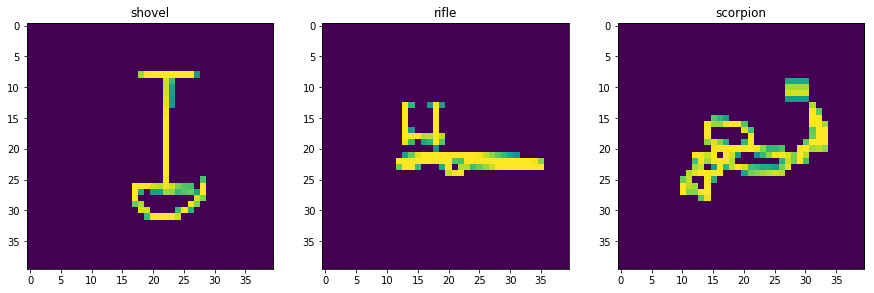

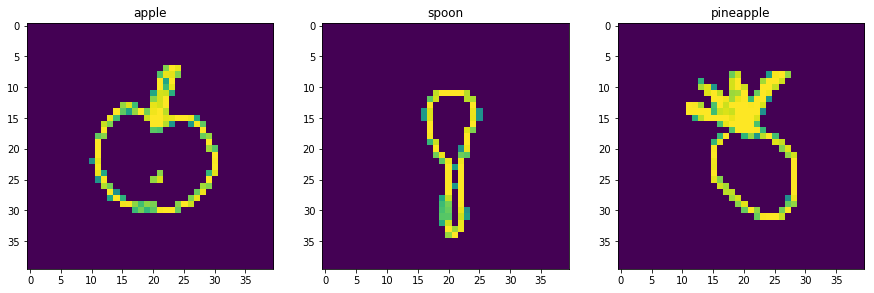

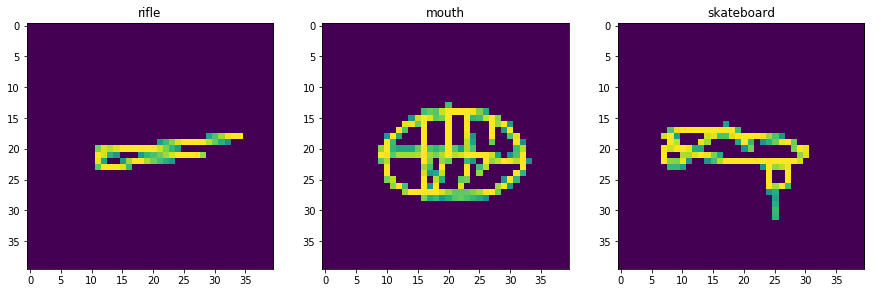

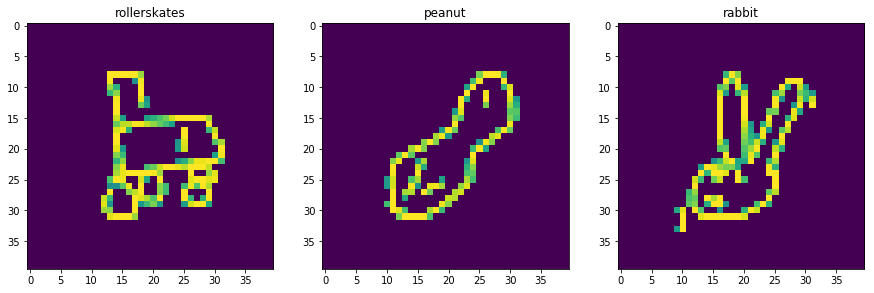

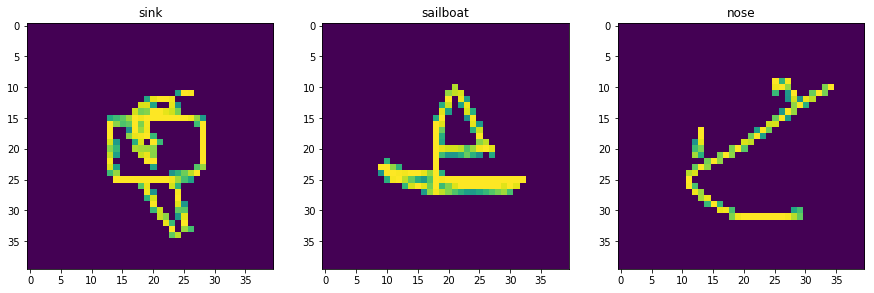

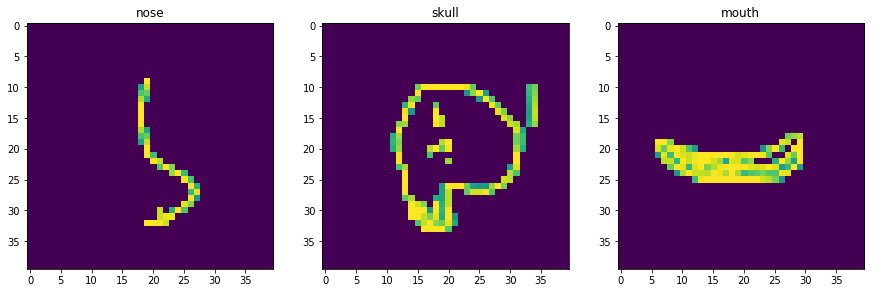

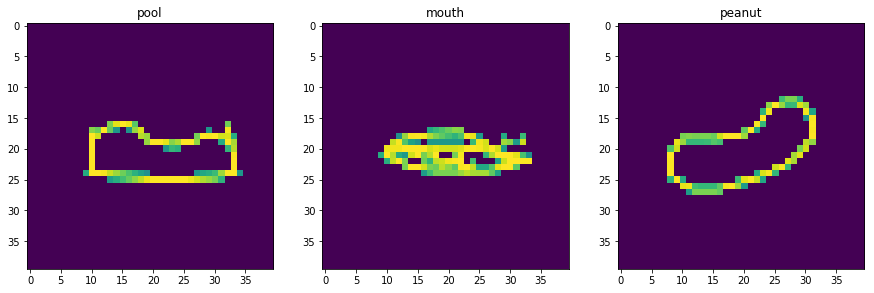

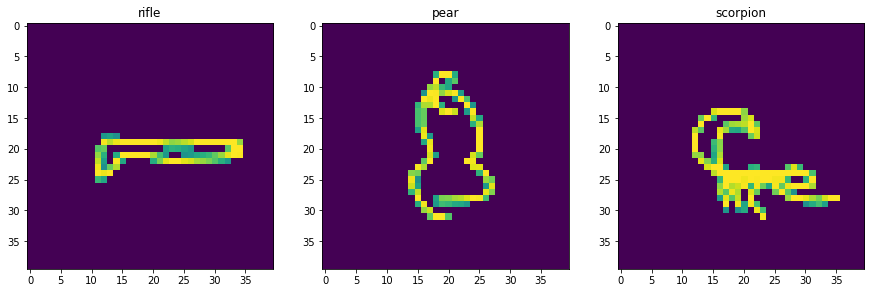

In [101]:
for i in range(0, 24, 3):
    plt.figure(figsize=(15,15))
    a = plt.subplot(131)
    a.title.set_text(train_labels[i][1])
    plt.imshow(X_train[i])
    b = plt.subplot(132)
    b.title.set_text(train_labels[i+1][1])
    plt.imshow(X_train[i+1])
    c = plt.subplot(133)
    plt.imshow(X_train[i+2])
    c.title.set_text(train_labels[i+2][1])

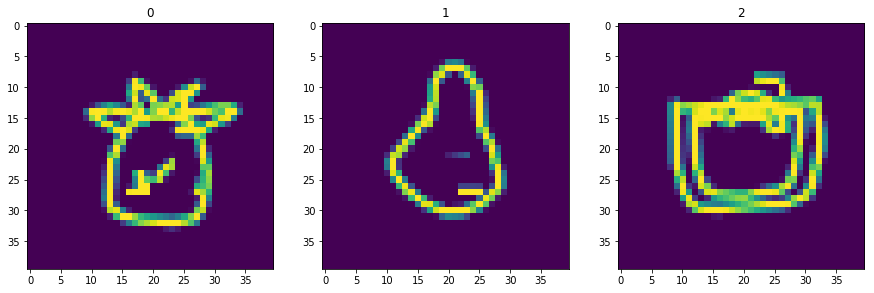

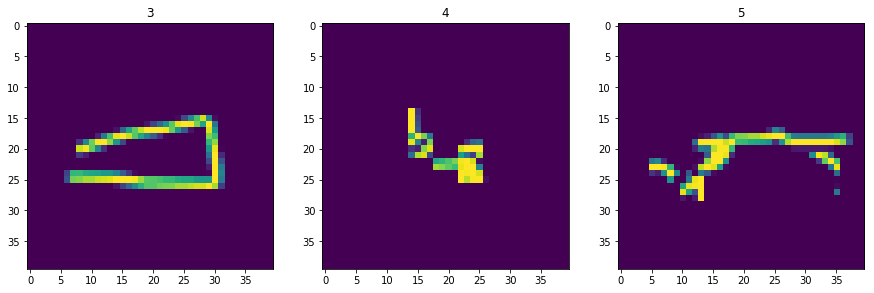

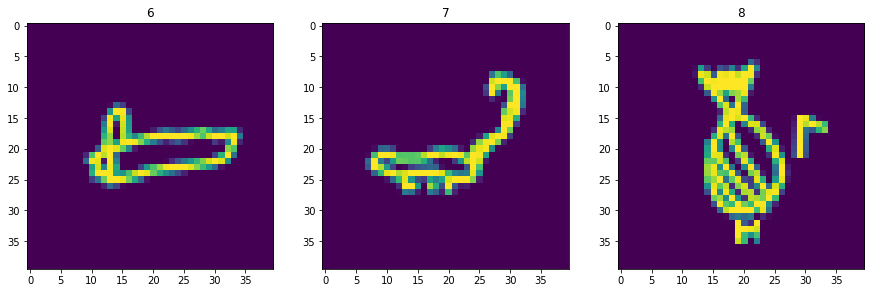

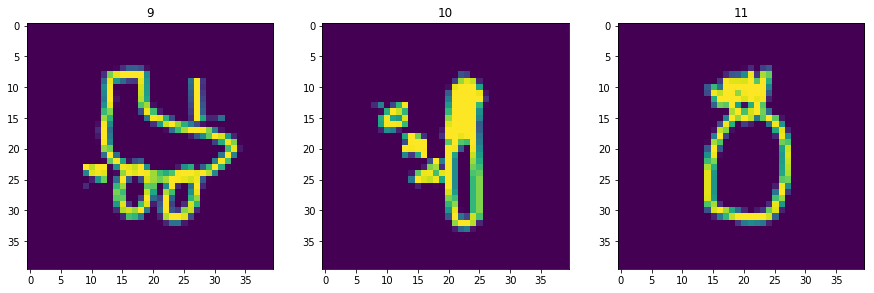

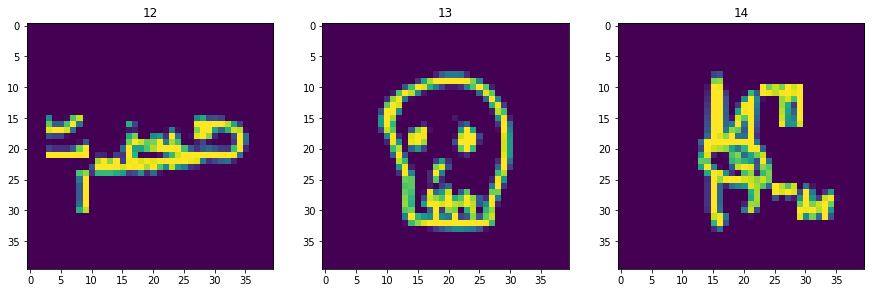

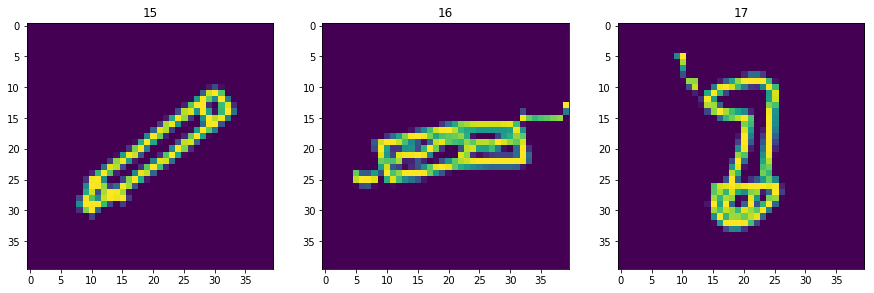

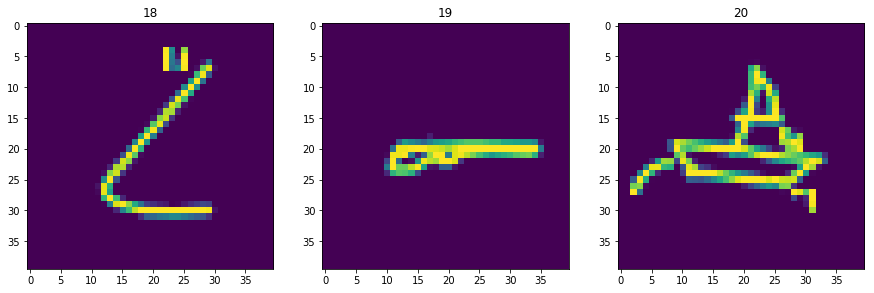

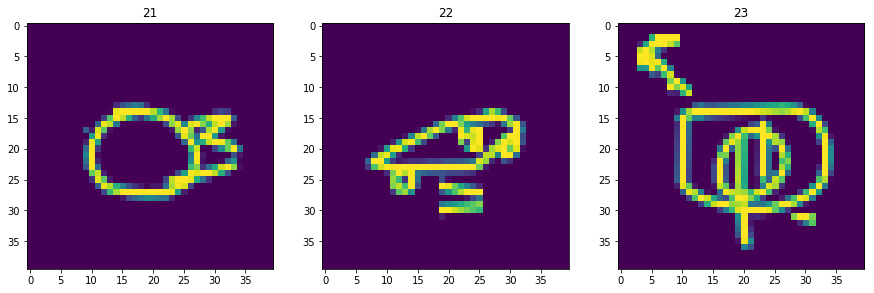

In [70]:
for i in range(0, 24, 3):
    plt.figure(figsize=(15,15))
    a = plt.subplot(131)
    a.title.set_text(i)
    plt.imshow(X_test[i])
    b = plt.subplot(132)
    b.title.set_text(i+1)
    plt.imshow(X_test[i+1])
    c = plt.subplot(133)
    plt.imshow(X_test[i+2])
    c.title.set_text(i+2)

In [9]:
X_valid = []
y_valid = []

X_tr = []
y_tr = []
for i in range(9500):
    X_tr.append(X_train[i])
    y_tr.append(train_labels[i][1])
for i in range(500):
    X_valid.append(X_train[i+9500])
    y_valid.append(train_labels[i+9500][1])

In [1]:
categories = []
for x in y_tr:
    if x not in categories:
        categories.append(x)
#categories

NameError: name 'y_tr' is not defined

In [11]:
y_tr_bb = []
for x in y_tr:
    y = categories.index(x)
    y_tr_bb.append(y)

In [12]:
y_va_bb = []
for x in y_valid: 
    y = categories.index(x)
    y_va_bb.append(y)

## CNN

In [44]:
train_X = np.array(X_tr).reshape(-1, 40,40, 1)
train_y = np.array(y_tr_bb)
#print(train_X.shape, train_y.shape)

(9500, 40, 40, 1) (9500,)


In [45]:
valid_X = np.array(X_valid).reshape(-1, 40,40, 1)
valid_y = np.array(y_va_bb)
#print(valid_X.shape, valid_y.shape)

(500, 40, 40, 1) (500,)


In [46]:
 #<--- FULL DATASET AS TRAIN --->
#tr_X_testing = np.append(X_tr, X_valid, axis=0)
#tr_y_testing = np.append(y_tr_bb, y_va_bb, axis=0)
#train_X_testing = np.array(tr_X_testing).reshape(-1, 40,40, 1)
#train_y_testing = np.array(tr_y_testing)
#print(train_X_testing.shape, train_y_testing.shape)

In [47]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, LeakyReLU, Dropout

In [48]:
model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=(40,40,1), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dropout(0.2))


model.add(Dense(2048, activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.35))


model.add(Dense(len(categories), activation='softmax'))

model.compile(optimizer="adam",metrics=["accuracy"],loss='sparse_categorical_crossentropy')

In [50]:
# Data Augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Add additional preprocessing function to ImageDataGenerator
# to randomly decide whether to threshold or not and then
# to randomly decide whether or not to find contour again and mask image

def random_preprocess(img):
  
  if np.random.randint(2):
    img = img.reshape(40,40)

    # Threshold image
    _, img = cv2.threshold(img, 0.4, 1, cv2.THRESH_TOZERO)
    
    if np.random.randint(2):
      _, contours, _ = cv2.findContours((img*255).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
      c = max(contours, key=lambda x : cv2.arcLength(cv2.convexHull(x),False))
      mask = cv2.drawContours(np.zeros(img.shape), [c], 0, 1, -1)
      mask = cv2.dilate(mask,(1,1),iterations = 1)
      img = img*mask
      
  if np.random.randint(2):
    # Add random noise pixel
    for i in range(np.random.randint(5)):
      num = np.random.randint(40*40)
      row,col = num//40, num%40
      img[row,col] = np.random.rand(1)
  
  return img.reshape(40,40,1)

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=5,
    height_shift_range=5,
    zoom_range=0.05,
    shear_range=1,
    horizontal_flip=True,
    preprocessing_function=random_preprocess
    )

In [51]:
# Train model
# Run this code block as many times as needed until convergence
# Should get a validation accuracy of about 83% after 5 iterations
for i in range(5): #2 #5 for 86.4 #4 when 84.3
  model.fit_generator(datagen.flow(train_X, train_y, batch_size=128), #128
                      steps_per_epoch=300, epochs=8, #300
                      validation_data=(valid_X, valid_y))

  model_train = model.fit(train_X, train_y, batch_size=128, epochs=8, validation_data=(valid_X, valid_y)) #128

Epoch 1/8
300/300 [==============================] - 17s 58ms/step - loss: 2.0069 - acc: 0.4293 - val_loss: 1.2313 - val_acc: 0.6820
Epoch 2/8
300/300 [==============================] - 16s 55ms/step - loss: 1.3517 - acc: 0.6149 - val_loss: 1.0144 - val_acc: 0.7440
Epoch 3/8
300/300 [==============================] - 17s 55ms/step - loss: 1.1707 - acc: 0.6630 - val_loss: 0.9069 - val_acc: 0.7480
Epoch 4/8
300/300 [==============================] - 17s 55ms/step - loss: 1.0566 - acc: 0.6932 - val_loss: 0.9246 - val_acc: 0.7840
Epoch 5/8
300/300 [==============================] - 17s 56ms/step - loss: 0.9925 - acc: 0.7119 - val_loss: 0.8404 - val_acc: 0.7900
Epoch 6/8
300/300 [==============================] - 17s 55ms/step - loss: 0.9241 - acc: 0.7301 - val_loss: 0.9136 - val_acc: 0.7820
Epoch 7/8
300/300 [==============================] - 17s 56ms/step - loss: 0.8798 - acc: 0.7446 - val_loss: 0.8867 - val_acc: 0.7720
Epoch 8/8
300/300 [==============================] - 17s 56ms/step - 

Epoch 5/8
9500/9500 [==============================] - 3s 317us/step - loss: 0.1090 - acc: 0.9625 - val_loss: 0.8538 - val_acc: 0.8340
Epoch 6/8
9500/9500 [==============================] - 3s 316us/step - loss: 0.1112 - acc: 0.9619 - val_loss: 0.9097 - val_acc: 0.8200
Epoch 7/8
9500/9500 [==============================] - 3s 317us/step - loss: 0.1018 - acc: 0.9641 - val_loss: 0.9094 - val_acc: 0.8320
Epoch 8/8
9500/9500 [==============================] - 3s 315us/step - loss: 0.0940 - acc: 0.9680 - val_loss: 0.8624 - val_acc: 0.8480
Epoch 1/8
300/300 [==============================] - 17s 55ms/step - loss: 0.5456 - acc: 0.8333 - val_loss: 0.8419 - val_acc: 0.8140
Epoch 2/8
300/300 [==============================] - 17s 56ms/step - loss: 0.5149 - acc: 0.8400 - val_loss: 0.8462 - val_acc: 0.8240
Epoch 3/8
300/300 [==============================] - 17s 55ms/step - loss: 0.5101 - acc: 0.8406 - val_loss: 0.8025 - val_acc: 0.8180
Epoch 4/8
300/300 [==============================] - 16s 55ms

In [53]:
for i in range(1): #1 for 86.4 #3 for 84.3
  model.fit_generator(datagen.flow(train_X, train_y, batch_size=512), 
                      steps_per_epoch=300, epochs=8, #10 for 84.3 #300 for 86.4
                      validation_data=(valid_X, valid_y))

  model_train = model.fit(train_X, train_y, batch_size=512, epochs=4, validation_data=(valid_X, valid_y)) #512 #only 4 epochs for 86.4

Train on 9500 samples, validate on 500 samples
Epoch 1/4
9500/9500 [==============================] - 2s 222us/step - loss: 0.0605 - acc: 0.9787 - val_loss: 0.8623 - val_acc: 0.8540
Epoch 2/4
9500/9500 [==============================] - 2s 212us/step - loss: 0.0503 - acc: 0.9827 - val_loss: 0.8830 - val_acc: 0.8520
Epoch 3/4
9500/9500 [==============================] - 2s 212us/step - loss: 0.0502 - acc: 0.9829 - val_loss: 0.9171 - val_acc: 0.8500
Epoch 4/4
9500/9500 [==============================] - 2s 212us/step - loss: 0.0590 - acc: 0.9777 - val_loss: 0.8913 - val_acc: 0.8580


In [23]:
#for i in range(2):
#  model.fit_generator(datagen.flow(train_X, train_y, batch_size=1024), 
#                      steps_per_epoch=20, epochs=8, #10
#                      validation_data=(valid_X, valid_y))

#  model_train = model.fit(train_X, train_y, batch_size=1024, epochs=8, validation_data=(valid_X, valid_y)) 

Epoch 1/8
20/20 [==============================] - 8s 388ms/step - loss: 0.4944 - acc: 0.8493 - val_loss: 0.8263 - val_acc: 0.8380
Epoch 2/8
20/20 [==============================] - 8s 379ms/step - loss: 0.4700 - acc: 0.8516 - val_loss: 0.8466 - val_acc: 0.8460
Epoch 3/8
20/20 [==============================] - 8s 383ms/step - loss: 0.4538 - acc: 0.8564 - val_loss: 0.8148 - val_acc: 0.8400
Epoch 4/8
20/20 [==============================] - 8s 383ms/step - loss: 0.4506 - acc: 0.8612 - val_loss: 0.8131 - val_acc: 0.8420
Epoch 5/8
20/20 [==============================] - 8s 381ms/step - loss: 0.4393 - acc: 0.8611 - val_loss: 0.8213 - val_acc: 0.8460
Epoch 6/8
20/20 [==============================] - 8s 381ms/step - loss: 0.4479 - acc: 0.8619 - val_loss: 0.8527 - val_acc: 0.8380
Epoch 7/8
20/20 [==============================] - 8s 396ms/step - loss: 0.4457 - acc: 0.8594 - val_loss: 0.8248 - val_acc: 0.8420
Epoch 8/8
20/20 [==============================] - 8s 378ms/step - loss: 0.4321 - a

In [50]:
test_eval = model.evaluate(valid_X, valid_y, verbose=0)

In [139]:
#incorrects = np.nonzero(model.predict_classes(valid_X).reshape((-1,)) != valid_y)

In [86]:
#incorrects_noPrePr = np.nonzero(model.predict_classes(valid_X).reshape((-1,)) != valid_y)

In [2]:
#sorted(valid_y[incorrects])

In [3]:
#sorted(valid_y[incorrects])

0.8560000061988831


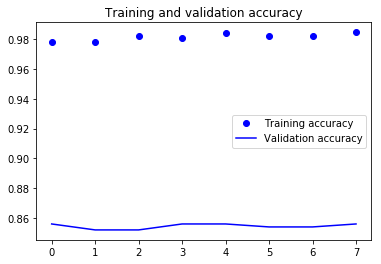

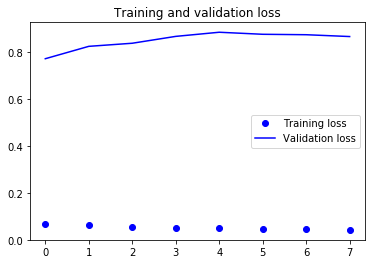

In [51]:
accuracy = model_train.history['acc']
val_accuracy = model_train.history['val_acc']
print(max(val_accuracy))
loss = model_train.history['loss']
val_loss = model_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [29]:
#y_test_pred = model.predict_classes(np.array(X_test).reshape(-1, 40, 40, 1))
#labels = list(map(lambda i : categories[i],y_test_pred))
#pd.DataFrame({"Category":labels, "Id":np.arange(len(labels))})[["Id","Category"]].to_csv("output.csv",index=False)

In [93]:
#x=collections.Counter(sorted(y_test_pred))
#print(x)
#x=collections.Counter(sorted(train_y))
#print(x)
#x=collections.Counter(sorted(valid_y))
#print(x)

Counter({6: 592, 5: 496, 15: 470, 22: 449, 1: 443, 23: 435, 12: 432, 7: 425, 21: 409, 19: 381, 30: 376, 10: 375, 2: 367, 3: 365, 18: 350, 24: 313, 14: 299, 8: 284, 20: 279, 17: 272, 11: 263, 0: 250, 29: 225, 9: 204, 16: 203, 13: 197, 25: 193, 26: 188, 4: 175, 27: 165, 28: 125})
Counter({6: 548, 5: 459, 15: 450, 22: 445, 23: 435, 1: 420, 12: 398, 19: 390, 7: 388, 30: 367, 2: 358, 10: 350, 3: 349, 21: 308, 18: 304, 24: 299, 8: 279, 14: 269, 11: 258, 0: 255, 17: 255, 20: 238, 29: 210, 26: 202, 25: 201, 13: 193, 9: 189, 27: 177, 16: 175, 4: 173, 28: 158})
Counter({7: 32, 15: 29, 23: 28, 12: 24, 6: 23, 22: 23, 5: 22, 1: 20, 19: 20, 3: 19, 10: 19, 14: 19, 2: 18, 18: 17, 21: 15, 24: 15, 30: 15, 8: 14, 11: 14, 20: 14, 16: 13, 17: 13, 13: 11, 9: 10, 25: 10, 29: 10, 0: 9, 4: 9, 28: 6, 27: 5, 26: 4})
